# STT 알고리즘을 활용하여 뉴스 요약하기

### 사용 라이브러리
- **ffmpeg** : 비디오, 오디오, 이미지를 쉽게 인코딩, 디코딩할 수 있도록 도움을 주는 멀티미디어 프레임워크
- **gensim** : 자연어를 벡터로 변환하는데 필요한 대부분의 편의기능을 제공하고 있는 라이브러리 (ex. Word2vec)
- **ETRI open API** : 다양한 인공지능 기술을 제공하는 오픈소스 (ex. STT)

### 구현 방법
1. 영상 다운로드(from Youtube)
2. 영상 전처리(ffmpeg)
3. STT(speech-to-text)(ETRI API)
4. Text 전처리
5. Text 요약(gensim)

In [1]:
import subprocess
import os
from gensim.summarization.summarizer import summarize

- gensim.summarizer 기능은 3.8 version이하로만 제공하므로 downgrade가 필요하다.

### Youtube 뉴스 다운로드
- url을 불러와 다운로드 한다.

In [3]:
youtube_url = "https://www.youtube.com/watch?v=mkIPcaKB2DY"
subprocess.call(["youtube-dl","-o", "%(title)s.%(ext)s", youtube_url.split("=")[-1]])

0

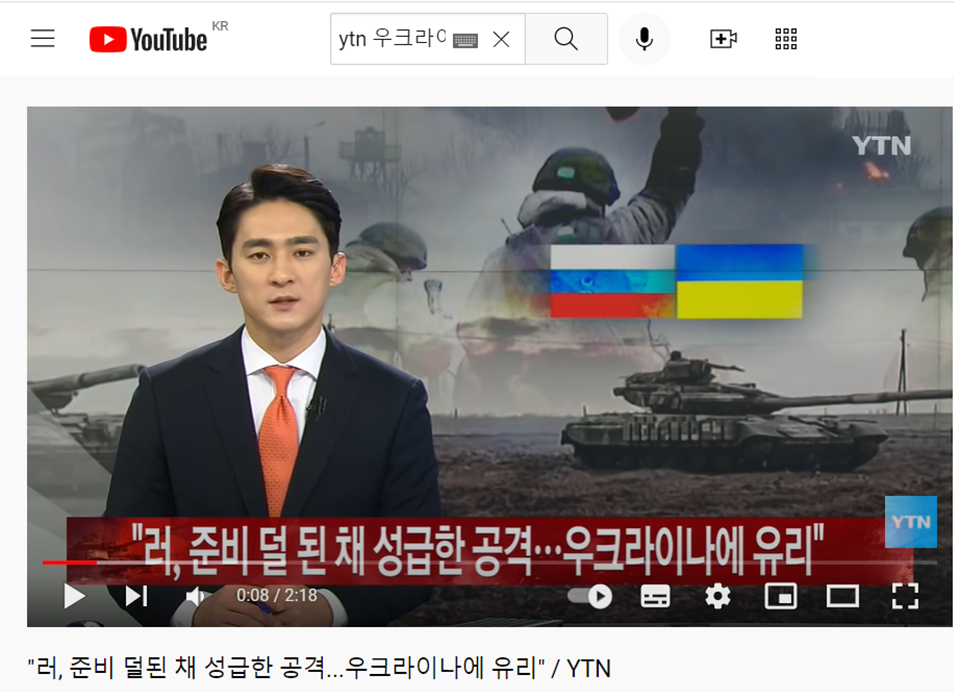

### 영상 전처리

#### 1) 오디오 추출

In [4]:
# mp4 파일 중 첫번째 파일만 임의로 선택
filelist = [file for file in os.listdir(".") if file.endswith(".mp4")]
file = filelist[0]

# audio추출
## -y : 이미존재하는 파일의 경우, overwriting할 수 있도록 설정
subprocess.call(["ffmpeg","-y", "-i", file, "output.mp3"])

0

#### 2) mp3파일을 wav파일로 변경

In [5]:
# mp3 -> wav로 변경
## -y : 이미존재하는 파일의 경우, overwriting할 수 있도록 설정
## -ar : sampling rate (etri의 경우 16khz지원)
## -ac : 1 (mono)
subprocess.call(["ffmpeg","-y" ,"-i", "output.mp3","-ac", "1", "-ar", "16000", "output.wav"])

0

#### 3) 오디오 파일 자르기

- 영상의 길이가 2분 18초이므로 69초 단위로 나누어주었다.

In [19]:
subprocess.call(["ffmpeg", "-i", \
                 "output.wav", \
                 "-f", "segment", "-segment_time", "30", \
                 "-c", "copy", "output%02d.wav"])

0

### STT 알고리즘 호출 (from ETRI API)

In [20]:
#coding:utf-8 -*-
import urllib3
import json
import base64
import json

In [21]:
openApiURL = "http://aiopen.etri.re.kr:8000/WiseASR/Recognition"
#인증키
accessKey = "562d11dd-818f-4264-b584-6f367c89d332"

def etri_stt(audioFilePath):
    languageCode = "korean"

    file = open(audioFilePath, "rb")
    audioContents = base64.b64encode(file.read()).decode("utf8")
    file.close()

    requestJson = {
        "access_key": accessKey,
        "argument": {
            "language_code": languageCode,
            "audio": audioContents
        }
    }

    http = urllib3.PoolManager()
    response = http.request(
        "POST",
        openApiURL,
        headers={"Content-Type": "application/json; charset=UTF-8"},
        body=json.dumps(requestJson)
    )

    print("[responseCode] " + str(response.status))
    print("[responBody]")
    print("===== 결과 확인 ====")
    data = json.loads(response.data.decode("utf-8", errors='ignore'))    
    print(data['return_object']['recognized'])
    
    return data['return_object']['recognized']

In [29]:
filelist = [file for file in os.listdir("C:/Users/hyoseok/data_science practice/STT_news") if file.startswith("output0") ]
# 해당 디렉토리의 output0으로 시작하는 파일을 불러옴
text_stacked = ""
for file in filelist:
    print(file)
    text = etri_stt(file)
    text_stacked += text
    
print(text_stacked)

output00.wav
[responseCode] 200
[responBody]
===== 결과 확인 ====
러시아군이 다음 달 9일 이차 세계 대전 승전 기념일까지 우크라이나 침공 성과를 내기 위해 돈바스 공격을 서두르고 있다는 관측이 나왔습니다 준비가 덜 된 러시아가 성급하게 공격하면 오히려 우크라이나에 유리할 거라는 분석도 있습니다 보도에 김현근 기자입니다 우크라
output01.wav
[responseCode] 200
[responBody]
===== 결과 확인 ====
제스터도 그리시스 마스 소크리와 뉴욕 소니스트 포르니 본토 요노 소스트리터 GN의 조를 지역으로 지으니까 미국 전쟁 연구소는 러시아군이 돈 바스 공격을 성급하게 서두르고 있다고 분석했습니다 아직 대규모 공격을 시작할 만큼 보급이나 지휘 통제 능력을 갖추지 못한 상황
output02.wav
[responseCode] 200
[responBody]
===== 결과 확인 ====
효율성이 떨어지고 성공 가능성도 줄어들 수 있다고 분석했습니다 그런데도 러시아군이 공격을 서두르는 건 2차대전 전승 기념일인 다음 달 9일까지 전쟁 성과를 내야 하기 때문으로 추정했습니다 푸틴 러시아 대통령이 그걸 원하고 있다는 겁니다.
output03.wav
[responseCode] 200
[responBody]
===== 결과 확인 ====
또 우크라이나군을 압도할 만큼 충분하지 않다고 진단했습니다. 하지만 화력 면에서는 러시아가 현재 월등히 우세하다는 평가입니다. 때문에 우크라이나로서는 서방 측으로부터 무기를 빨리 지원받아서 배치하는 게 무엇보다 중요해졌습니다.
output04.wav
[responseCode] 200
[responBody]
===== 결과 확인 ====
헤라소스나, 제임스 위조, 그레이너, 드래머, 딥비추스 집, 미스모스 브리트 와드 부크레인 소방 측은 돈바스 전투가 본격화됨에 따라 무기 지원과 사용법 전술을 서두르고 있습니다. YTN 김영근입니다.
러시아군이 다음 달 9일 이차 세계 대전

### Text 전처리

In [30]:
#구두점 삽입
punctuation_text = text_stacked.replace("니다", "니다.") #습니다. 입니다.
punctuation_text

'러시아군이 다음 달 9일 이차 세계 대전 승전 기념일까지 우크라이나 침공 성과를 내기 위해 돈바스 공격을 서두르고 있다는 관측이 나왔습니다. 준비가 덜 된 러시아가 성급하게 공격하면 오히려 우크라이나에 유리할 거라는 분석도 있습니다. 보도에 김현근 기자입니다. 우크라제스터도 그리시스 마스 소크리와 뉴욕 소니스트 포르니 본토 요노 소스트리터 GN의 조를 지역으로 지으니까 미국 전쟁 연구소는 러시아군이 돈 바스 공격을 성급하게 서두르고 있다고 분석했습니다. 아직 대규모 공격을 시작할 만큼 보급이나 지휘 통제 능력을 갖추지 못한 상황효율성이 떨어지고 성공 가능성도 줄어들 수 있다고 분석했습니다. 그런데도 러시아군이 공격을 서두르는 건 2차대전 전승 기념일인 다음 달 9일까지 전쟁 성과를 내야 하기 때문으로 추정했습니다. 푸틴 러시아 대통령이 그걸 원하고 있다는 겁니다..또 우크라이나군을 압도할 만큼 충분하지 않다고 진단했습니다.. 하지만 화력 면에서는 러시아가 현재 월등히 우세하다는 평가입니다.. 때문에 우크라이나로서는 서방 측으로부터 무기를 빨리 지원받아서 배치하는 게 무엇보다 중요해졌습니다..헤라소스나, 제임스 위조, 그레이너, 드래머, 딥비추스 집, 미스모스 브리트 와드 부크레인 소방 측은 돈바스 전투가 본격화됨에 따라 무기 지원과 사용법 전술을 서두르고 있습니다.. YTN 김영근입니다..'

### Text 요약

In [31]:
print(summarize(punctuation_text, word_count=50))

러시아군이 다음 달 9일 이차 세계 대전 승전 기념일까지 우크라이나 침공 성과를 내기 위해 돈바스 공격을 서두르고 있다는 관측이 나왔습니다.
우크라제스터도 그리시스 마스 소크리와 뉴욕 소니스트 포르니 본토 요노 소스트리터 GN의 조를 지역으로 지으니까 미국 전쟁 연구소는 러시아군이 돈 바스 공격을 성급하게 서두르고 있다고 분석했습니다.
